<h2 style='color: orange'>Équipe: Louis & Emire</h2>

### 5. Comparaison des performances entre les méthodes linéaires vs méthodes non-linéaires pour la prédiction sur de vraies données transcriptomiques des cancers de TCGA.

# Index

1. [Régression linéaire vs DNN](./projet_tp6_rc_dnn_louis_emire.ipynb)
2. [Régression linéaire vs Auto-Encodeur linéaire](./projet_tp6_rc_lae_louis_emire.ipynb)
3. [PCA 2D & Auto-Encodeur linéaire](./projet_tp6_pca2d_lae_louis_emire.ipynb)

# Workplan

1. Review litterature about the type of ML algorithms and their models
2. Data importation: `TCGA dataset`
3. Data preprocessing -> experience data
4. Algorithms/models configuration
5. Models training
6. Comparison with figures
   - 2 clusters containing maximum 4 figures each.
   - 1 classification plot for each algorithm (2 in total for each cluster)

In [113]:
# Librairies
import matplotlib.pyplot as plt
import numpy as np
import torch
import itertools
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix
from utils.DataSet import DataSet

In [114]:
# Data importation and pre-processing

data_set = DataSet('./data/TCGA_TPM_hv_subset.h5')

figures_directory = "./figures/project"

data = data_set.get_data('data', float)

genes = data_set.get_data('cols', str)
labels = data_set.get_data('labels', str)
rows = data_set.get_data('rows', str)

cleaned_labels = [lbl.split('-')[-1] for lbl in np.unique(labels)]

Confusion matrix

Text(0.5, 0.92, 'Figure 1. Ridge classifier vs DNN performance analysis on classification of cancer type in TCGA data')

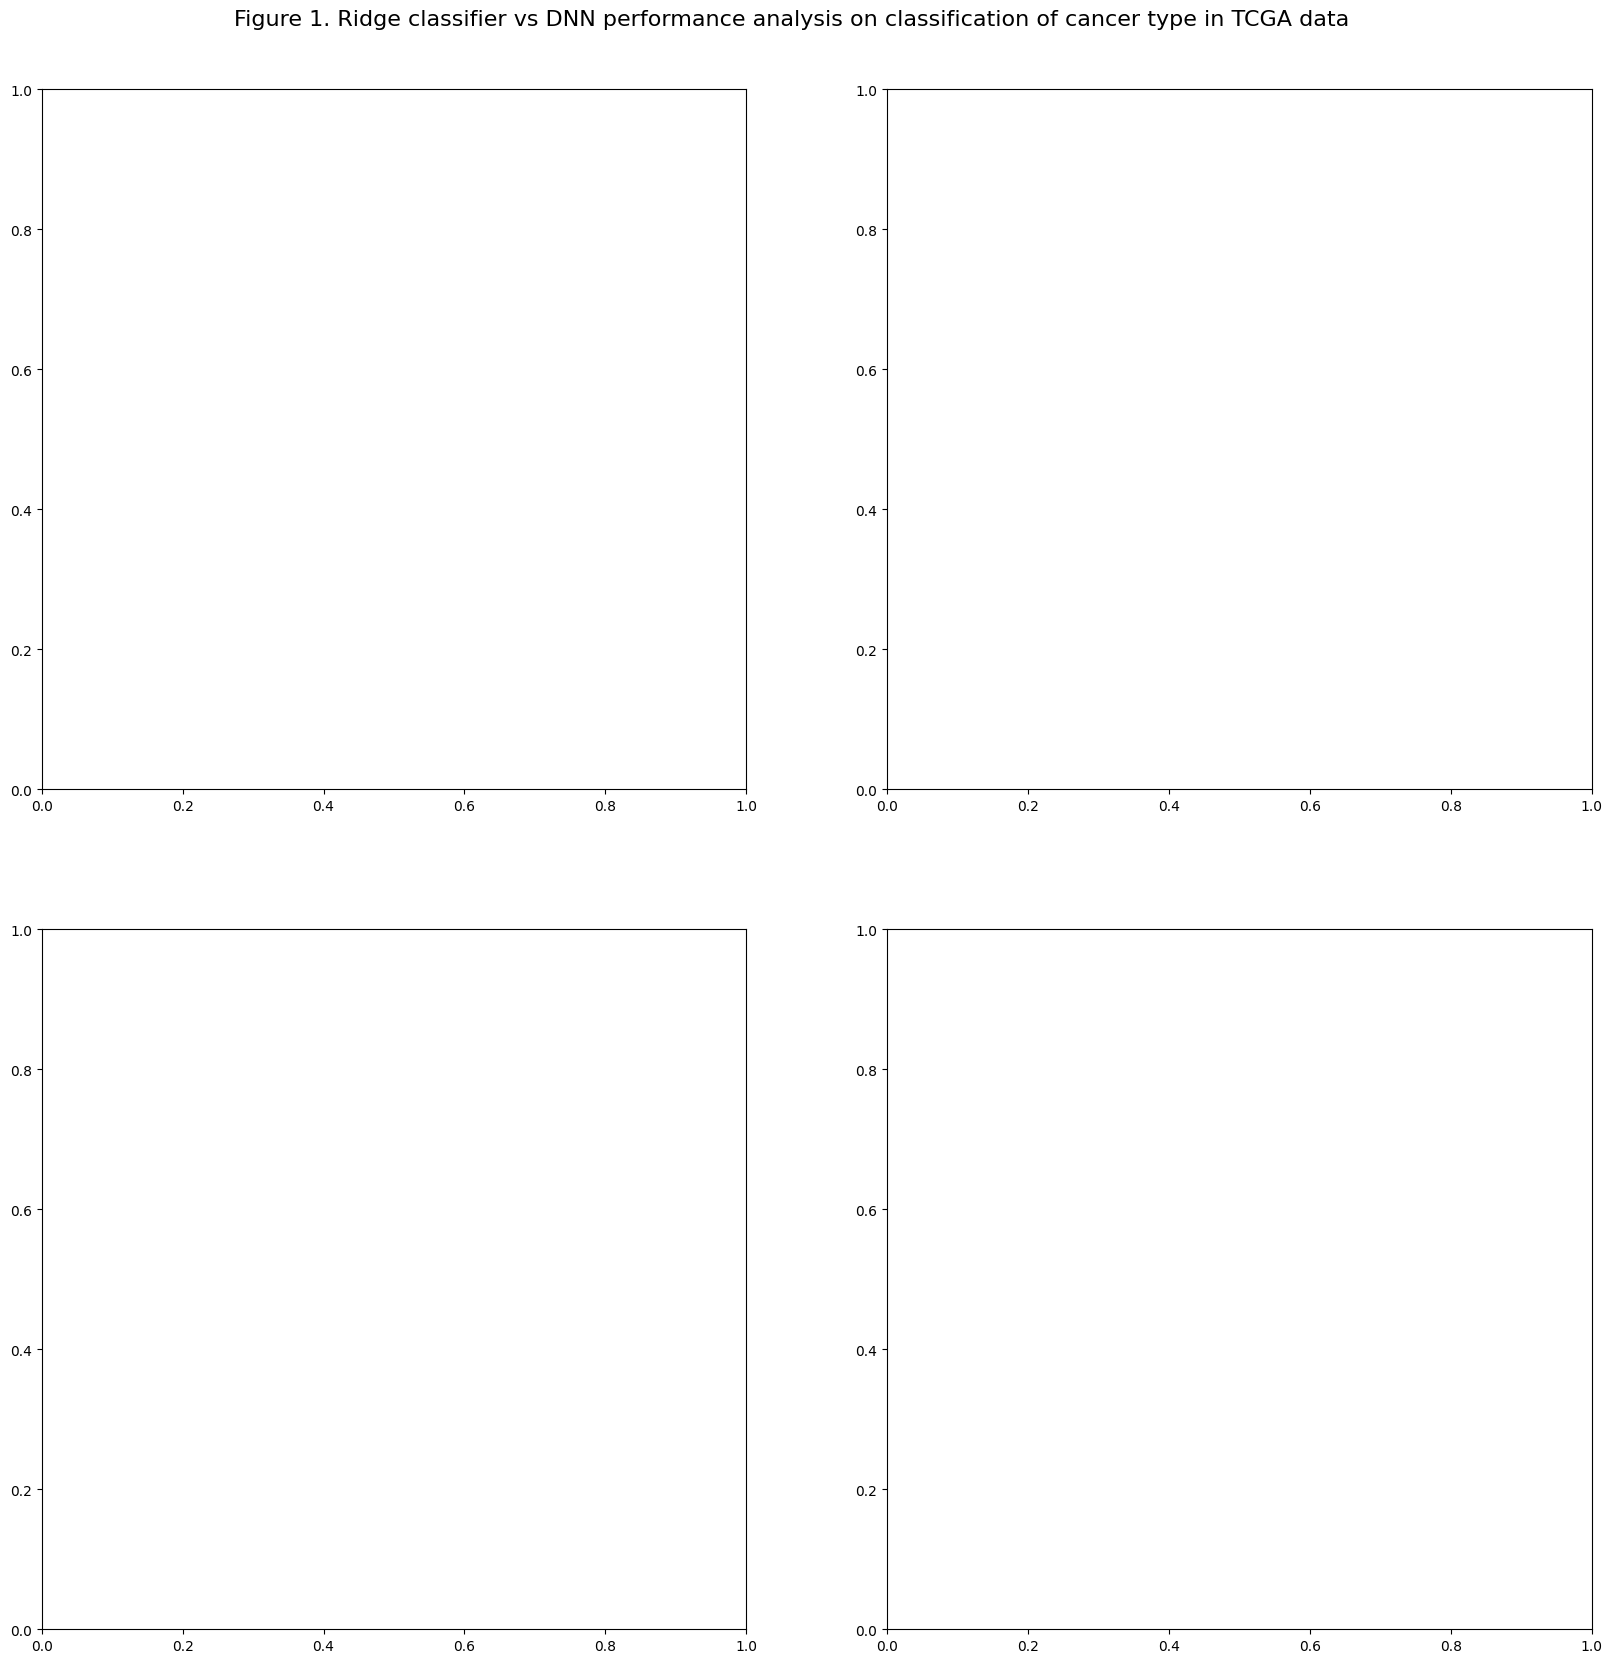

In [115]:
fig, axs = plt.subplots(2, 2, figsize = (20, 20))
fig.suptitle('Figure 1. Ridge classifier vs DNN performance analysis on classification of cancer type in TCGA data', fontsize=16, y=0.92)

### A. Pour la classification moléculaires entre la régression linéaire et un DNN, quelle méthode fonctionne le mieux et pourquoi?


#### Régression Logistique

In [116]:
max_iter = 100
X_train, X_test, Y_train, Y_test = train_test_split(data.T, labels, test_size= 0.2)
log_clf = RidgeClassifier(alpha=1e-4, solver ="lsqr", max_iter = max_iter)
log_clf.fit(X_train, Y_train)

train_set_accuracy = round((np.mean(log_clf.predict(X_train) == Y_train)), 2) * 100
test_set_accuracy = round((np.mean(log_clf.predict(X_test) == Y_test)), 2) * 100

print(f"Accuracy on train set (n = {X_train.shape[0]}): {train_set_accuracy}%")
print(f"Accuracy on test set (n = {X_test.shape[0]}): {test_set_accuracy}%")
print(f"Number of errors : {(np.sum(log_clf.predict(X_test) != Y_test)) }")

Accuracy on train set (n = 8276): 100.0%
Accuracy on test set (n = 2070): 96.0%
Number of errors : 74


Confusion matrix

In [117]:
cm = confusion_matrix(log_clf.predict(X_test),  Y_test)

axs[0,0].imshow(cm, cmap='Oranges', vmin=cm.min(), vmax=cm.max())
axs[0,0].set_xticks(np.arange(len(np.unique(labels))), labels = cleaned_labels, rotation = 45, ha='right')
axs[0,0].set_yticks(np.arange(len(np.unique(labels))), labels = cleaned_labels)
axs[0,0].set_xlabel("Predicted Labels", fontsize=12)
axs[0,0].set_ylabel("True Labels", fontsize=12)
axs[0,0].set_title("1.a Ridge classifier confusion matrix on test set", fontsize=14)

thresh = cm.max() / 1.5

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if cm[i, j] != 0:
        axs[0,0].text(j, i, "{:,}".format(cm[i, j]),
        horizontalalignment="center",
    color="white" if cm[i, j] > thresh else "black")

Errors plot

In [118]:
# Get predictions
predictions = log_clf.predict(X_test)

# Find indices where predictions and actual values differ
error_indices = np.where(predictions != Y_test)[0]

# Adjust this based on your actual data
axs[1,0].scatter(X_test[error_indices, 0], X_test[error_indices, 1], color='orange', label='Errors')

# Optionally, plot correct predictions for comparison
correct_indices = np.where(predictions == Y_test)[0]
axs[1,0].scatter(X_test[correct_indices, 0], X_test[correct_indices, 1], color='#4B0082', alpha=0.5, label='Correct')

axs[1,0].set_xlabel('RC 1', fontsize=12)
axs[1,0].set_ylabel('RC 2', fontsize=12)
axs[1,0].set_title(f'1.b Ridge classifier errors plot on test set\nAccuracy : {test_set_accuracy}% ; Iters = {max_iter}', fontsize=14)
axs[1,0].legend()

#### DNN

Data

In [119]:
lblbin = LabelBinarizer()

targets = lblbin.fit_transform(labels)

X, Y = torch.Tensor(data.T), torch.Tensor(targets)

X_train, X_test, Y_train, Y_test = [torch.Tensor(split) for split in train_test_split(data.T, targets, test_size = 0.2)]

Model

In [120]:
class NeuralNetwork(nn.Module):
    def __init__(self, insize, outsize):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(insize, 100), # couche entrée
            nn.Linear(100, 100), # couche cahée
            nn.Linear(100, outsize)  # couche sortie
        )

    def train(self, nepochs = 1000, printstep = 100):
        mm = self.linear_relu_stack        
        optimizer = torch.optim.Adam(mm.parameters(), lr = 1e-4)
        tr_losses, tst_losses, tr_accs, tst_accs = [], [], [], []
        # boucle de training 
        for i in range(nepochs):
            #####
            optimizer.zero_grad() # required*
            out_tr = mm(X_train) # calcul 'avant'
            tr_error = nn.functional.cross_entropy(out_tr, Y_train)
            out_test = mm(X_test)
            tst_error = nn.functional.cross_entropy(out_test, Y_test)
            tr_acc = np.mean(np.array( out_tr.max(1).indices == Y_train.max(1).indices))
            tst_acc = np.mean(np.array( out_test.max(1).indices == Y_test.max(1).indices))
            [tr_losses.append(float(tr_error)),tst_losses.append(float(tst_error)),
            tr_accs.append(tr_acc), tst_accs.append(tst_acc)]
            tr_error.backward() # calcul 'arriere' et mise a jour
            optimizer.step() # required*
            if i % printstep == 0 or i == nepochs - 1:
                print(f"{i} Loss Train : {round(float(tr_error) * 100,2)} - Acc: {round(tr_acc * 100,2)} \
                    - Test : {round(float(tst_error) * 100,2)} - Acc: {round(tst_acc * 100,2)} \
                        - errors: {np.sum(np.array( out_test.max(1).indices != Y_test.max(1).indices))}")
        return mm, tr_losses, tst_losses, np.array(tr_accs), np.array(tst_accs)

    

Training

In [121]:
nni = NeuralNetwork(X_train.shape[1], Y_train.shape[1])
mm, tr_losses, tst_losses, tr_accs, tst_accs = nni.train(nepochs = 1000, printstep = 100)

0 Loss Train : 346.43 - Acc: 3.87                     - Test : 346.88 - Acc: 3.33                         - errors: 2001
100 Loss Train : 25.28 - Acc: 93.75                     - Test : 27.64 - Acc: 93.38                         - errors: 137
200 Loss Train : 13.51 - Acc: 96.25                     - Test : 18.13 - Acc: 94.54                         - errors: 113
300 Loss Train : 8.26 - Acc: 98.22                     - Test : 15.07 - Acc: 95.07                         - errors: 102
400 Loss Train : 4.9 - Acc: 99.31                     - Test : 13.56 - Acc: 95.46                         - errors: 94
500 Loss Train : 2.91 - Acc: 99.82                     - Test : 12.88 - Acc: 95.65                         - errors: 90
600 Loss Train : 1.8 - Acc: 99.92                     - Test : 12.67 - Acc: 95.89                         - errors: 85
700 Loss Train : 1.18 - Acc: 99.98                     - Test : 12.68 - Acc: 95.85                         - errors: 86
800 Loss Train : 0.82 - Acc: 100.0  

Confusion matrix

In [122]:
pred_labs = [np.unique(labels)[x] for x in mm(X_test).max(1).indices]
true_labs = [np.unique(labels)[x] for x in Y_test.max(1).indices]

dnn_cm = confusion_matrix(pred_labs,  true_labs)

axs[0,1].imshow(dnn_cm, cmap='Blues', vmin=dnn_cm.min(), vmax=dnn_cm.max())
axs[0,1].set_xticks(np.arange(len(np.unique(labels))), labels = cleaned_labels, rotation = 45, ha='right')
axs[0,1].set_yticks(np.arange(len(np.unique(labels))), labels = cleaned_labels)
axs[0,1].set_xlabel("Predicted Labels", fontsize=12)
axs[0,1].set_ylabel("True Labels", fontsize=12)
axs[0,1].set_title("1.c DNN confusion matrix on test set", fontsize=14)

thresh = dnn_cm.max() / 1.5

for i, j in itertools.product(range(dnn_cm.shape[0]), range(dnn_cm.shape[1])):
    if dnn_cm[i, j] != 0:
        axs[0,1].text(j, i, "{:,}".format(dnn_cm[i, j]),
        horizontalalignment="center",
    color="white" if dnn_cm[i, j] > thresh else "black")

Learning curves

In [125]:
axs[1, 1].cla()

markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])

steps = np.arange(len(tr_losses))

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='orange', lw=2, linestyle='--'),
                Line2D([0], [0], color='purple', lw=2, linestyle='--')]

# First plot (Losses) on axs[0, 1]
axs[1, 1].plot(steps, tr_losses, label="train (loss)", color='green')
axs[1, 1].plot(steps, tst_losses, label="test (loss)", color='blue')
axs[1, 1].plot(steps[-1], tr_losses[-1], 'go', markersize=5, label=f'({steps[-1]}, {tr_losses[-1]:.2f})')
axs[1, 1].plot(steps[-1], tst_losses[-1], 'bv', markersize=5, label=f'({steps[-1]}, {tst_losses[-1]:.2f})')
axs[1, 1].set_ylabel("Cross entropy loss", fontsize=12)
axs[1, 1].set_xlabel("Epochs number", fontsize=12)
axs[1, 1].legend(loc='center right', bbox_to_anchor=(1, 0.575))

# Second plot (Accuracies) on the same subplot, but using a secondary y-axis
sec_ax = axs[1, 1].twinx()
sec_ax.plot(steps, tr_accs * 100, label="train (accuracy)", color='orange')
sec_ax.plot(steps, tst_accs * 100, label="test (accuracy)", color='purple')
sec_ax.plot(steps[-1], tr_accs[-1] * 100, 'o', color='orange', markersize=5, label=f'({steps[-1]}, {tr_accs[-1]*100:.2f}%)')
sec_ax.plot(steps[-1], tst_accs[-1] * 100, 'v', color='purple', markersize=5, label=f'({steps[-1]}, {tst_accs[-1]*100:.2f}%)')
sec_ax.set_ylabel("Accuracy (%)", fontsize=12)
sec_ax.set_ylim((0, 102))
sec_ax.legend(loc='center right', bbox_to_anchor=(1, 0.425))

# Set the title for the combined plot
axs[1, 1].set_title(f"1.d Learning curves of DNN\nN={data.T.shape[1]} ; N(train)={X_train.shape[0]} ; N(test)={X_test.shape[0]} ; Learning Rate : 1e-4", fontsize=14)

Text(0.5, 1.0, '1.d Learning curves of DNN\nN=15165 ; N(train)=8276 ; N(test)=2070 ; Learning Rate : 1e-4')

Grouped

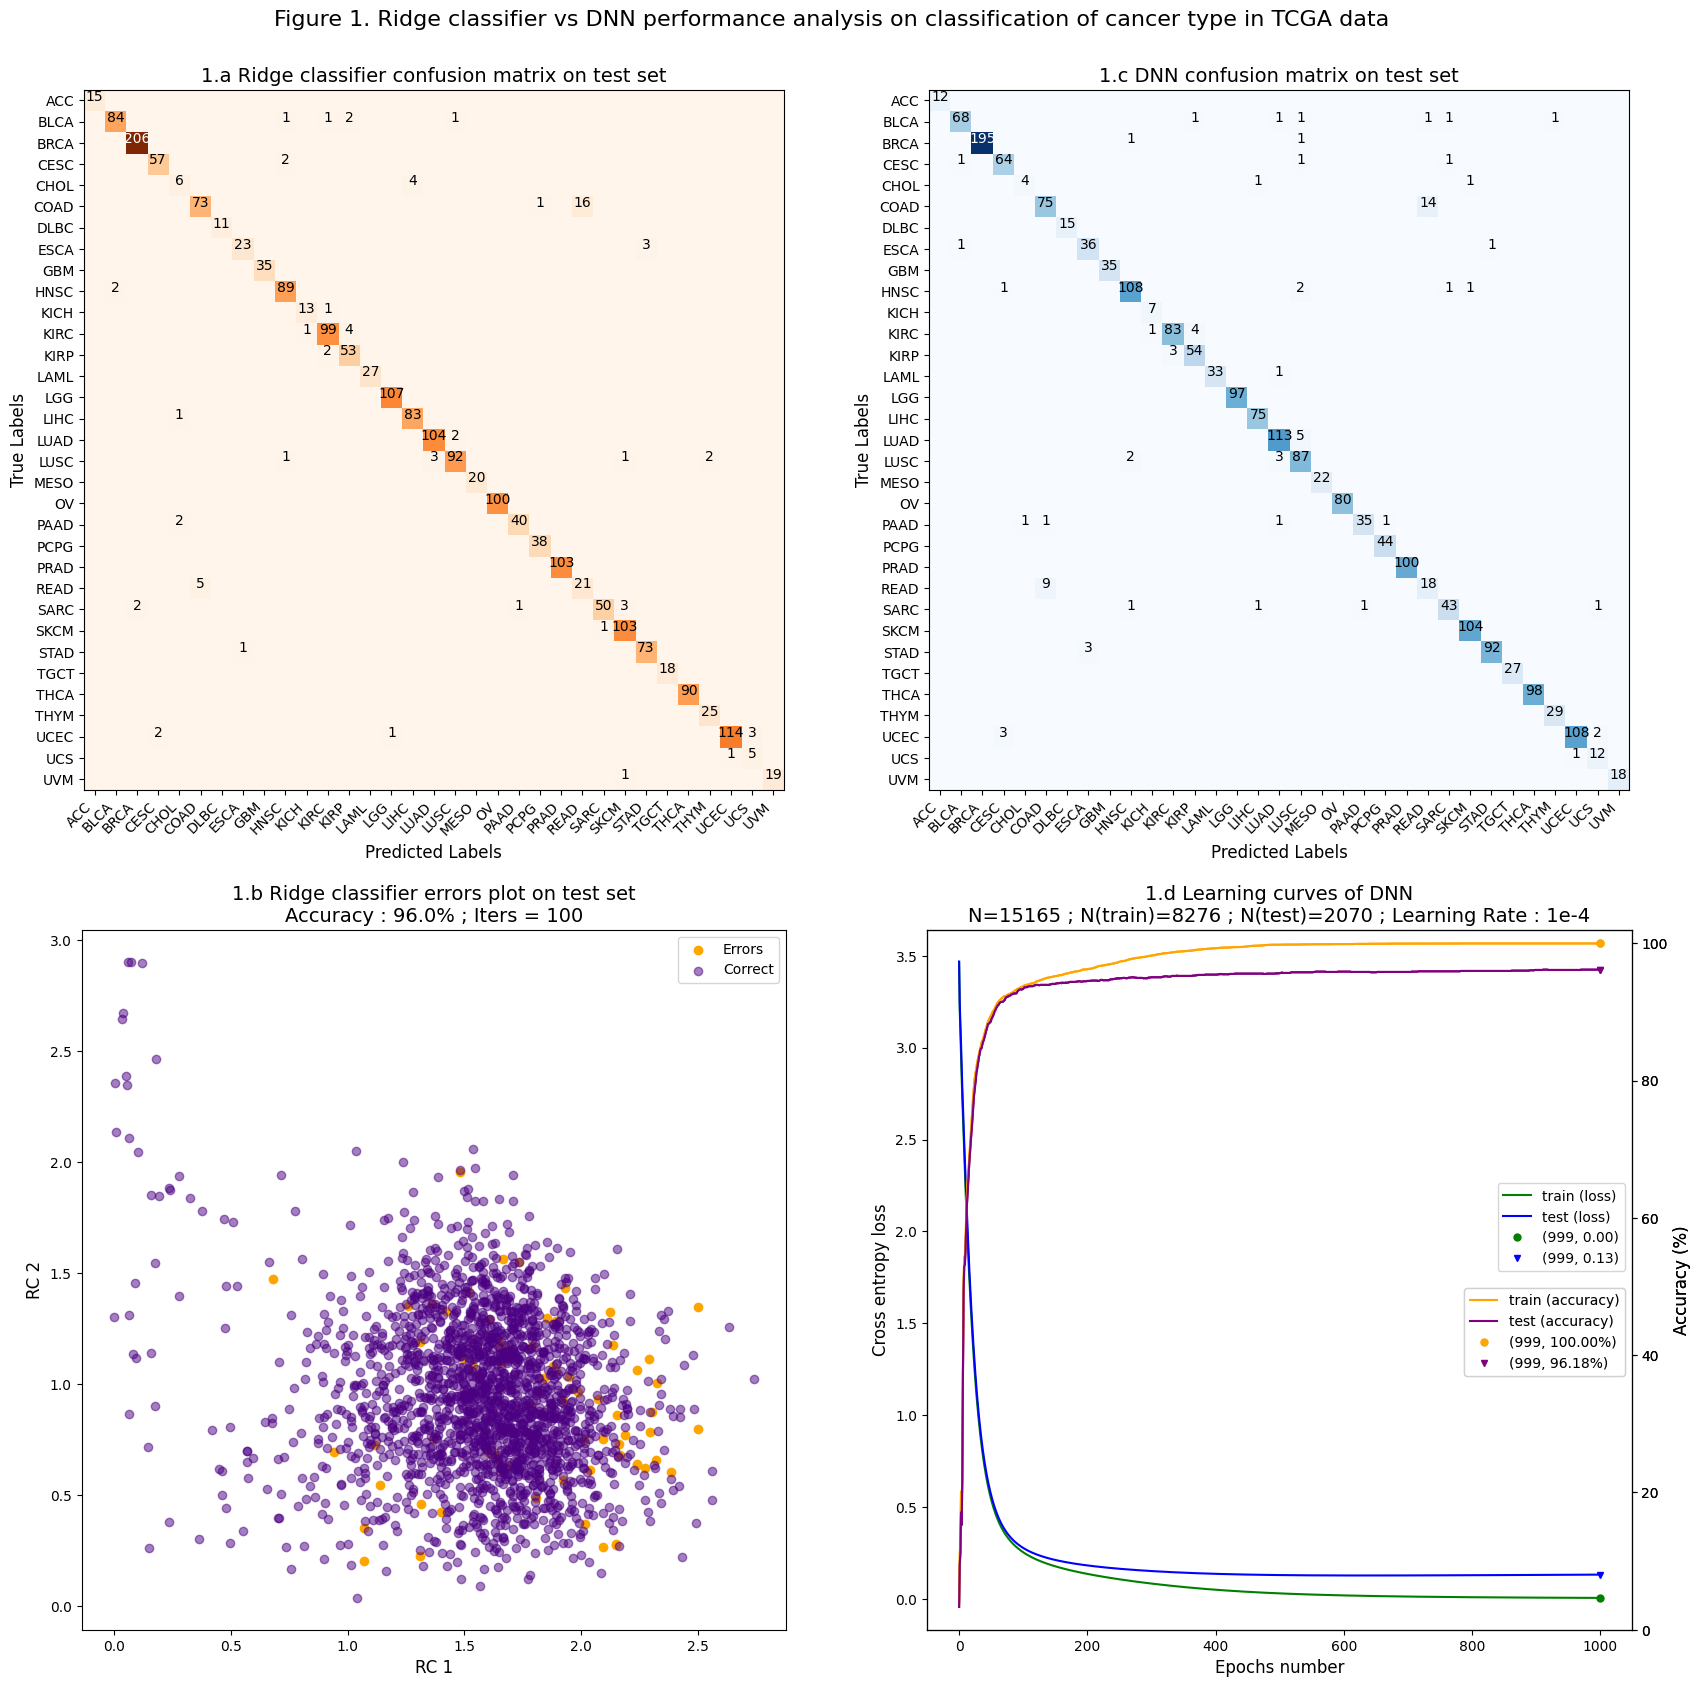

In [126]:
fig.savefig(f'{figures_directory}/rc_dnn_comparative_analysis_figures.svg', format='svg', bbox_inches='tight')
fig